In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Parameters

In [2]:
SPLIT_TEST_SIZE    = 0.2
SPLIT_RANDOM_STATE = 17

# Loading the Dataset

In [3]:
def load_data():
    data_set  = pd.read_csv('data/flight_delays_data.csv')

    return data_set

def preprocess_data(data_set):
    # alter first column values from c-1 to 1, c-2 to 2, c-3 to 3
    data_set['Month'] = data_set['Month'].apply(lambda x: int(x.split('-')[1]))
    data_set['DayofMonth'] = data_set['DayofMonth'].apply(lambda x: int(x.split('-')[1]))
    data_set['DayOfWeek'] = data_set['DayOfWeek'].apply(lambda x: int(x.split('-')[1]))

    # encode the categorical data using LabelEncoder
    le = LabelEncoder()
    data_set['UniqueCarrier'] = le.fit_transform(data_set['UniqueCarrier'])
    data_set['Origin'] = le.fit_transform(data_set['Origin'])
    data_set['Dest'] = le.fit_transform(data_set['Dest'])

    scaler = StandardScaler()
    for col in data_set.columns:
        if col != 'dep_delayed_15min':
            data_set[col] = scaler.fit_transform(data_set[col].values.reshape(-1, 1))

    return data_set

def numerical_label(data_set):
    data_set['dep_delayed_15min'] = data_set['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)

    return data_set

data_set = load_data()
data_set = preprocess_data(data_set)
data_set = numerical_label(data_set)
data_set.head()

Month  DayofMonth  DayOfWeek   DepTime  UniqueCarrier    Origin  \
0  0.428414    0.602254   1.530490  1.243715      -1.834390 -1.617426   
1 -0.743428    0.488538  -0.477915  0.433431       0.906906  0.970397   
2  0.721374   -1.558338   0.526288  0.168934       1.211494  1.113443   
3  1.307295    1.057115   1.028389 -0.685433       0.450023 -0.837178   
4  1.014335   -0.989761   1.028389  1.021202       1.059200  0.411219   

       Dest  Distance  dep_delayed_15min  
0 -0.821024  0.004530                  0  
1  0.390174  0.182040                  0  
2 -1.068473 -0.545405                  0  
3  0.442268  0.248172                  0  
4  0.754835 -0.533223                  1

# EDA (Exploratory Data Analysis)

## General Info

In [4]:
print(data_set.describe())
print(data_set.info())

# number of flights delayed and not delayed
print("\nNumber of flights delayed (1) and not delayed (0):")
flight_delay_counts = data_set['dep_delayed_15min'].value_counts()
print(flight_delay_counts)
print("Percentage of flights delayed: ", (flight_delay_counts[1]/(flight_delay_counts[0] + flight_delay_counts[1]))*100)

              Month    DayofMonth     DayOfWeek       DepTime  UniqueCarrier  \
count  1.000000e+05  1.000000e+05  1.000000e+05  1.000000e+05   1.000000e+05   
mean   1.015898e-16  9.894308e-17 -7.132073e-17  7.766232e-17  -6.998846e-18   
std    1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00   1.000005e+00   
min   -1.622310e+00 -1.672054e+00 -1.482118e+00 -2.814003e+00  -1.834390e+00   
25%   -7.434282e-01 -8.760461e-01 -9.800164e-01 -8.617643e-01  -9.206245e-01   
50%    1.354532e-01  3.367680e-02  2.418622e-02 -2.419072e-02   1.454349e-01   
75%    7.213741e-01  8.296843e-01  1.028389e+00  8.217796e-01   9.069058e-01   
max    1.600256e+00  1.739407e+00  1.530490e+00  2.503224e+00   1.363788e+00   

             Origin          Dest      Distance  dep_delayed_15min  
count  1.000000e+05  1.000000e+05  1.000000e+05       100000.00000  
mean  -1.433520e-16 -4.433787e-17  2.543743e-17            0.19044  
std    1.000005e+00  1.000005e+00  1.000005e+00            0.39265  
min

According to the percentage of the target classes, no-learning would result in %80 accuracy with the majority class prediction method. So we need to achieve higher than 80.

## Correlation Matrix

                      Month  DayofMonth  DayOfWeek   DepTime  UniqueCarrier  \
Month              1.000000    0.007106   0.004717 -0.001544       0.008111   
DayofMonth         0.007106    1.000000  -0.015537  0.001116       0.002717   
DayOfWeek          0.004717   -0.015537   1.000000  0.009392      -0.010054   
DepTime           -0.001544    0.001116   0.009392  1.000000       0.012335   
UniqueCarrier      0.008111    0.002717  -0.010054  0.012335       1.000000   
Origin             0.002504    0.000357   0.002445 -0.039127       0.075862   
Dest               0.008895   -0.000970  -0.000576  0.023091       0.074313   
Distance           0.006853    0.001510   0.011937 -0.020681      -0.232401   
dep_delayed_15min  0.016998    0.025842   0.010439  0.243819      -0.001706   

                     Origin      Dest  Distance  dep_delayed_15min  
Month              0.002504  0.008895  0.006853           0.016998  
DayofMonth         0.000357 -0.000970  0.001510           0.025842  
Da

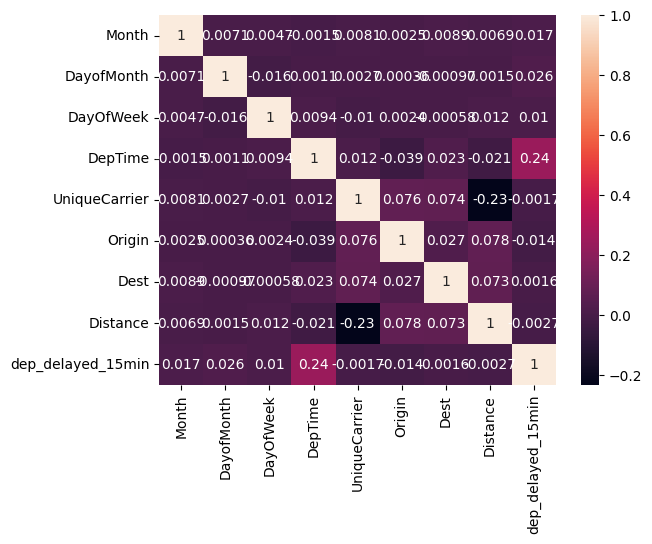

In [5]:
corr = data_set.corr()
print(corr)
sns.heatmap(corr, annot=True)
plt.show()

## Pairplot

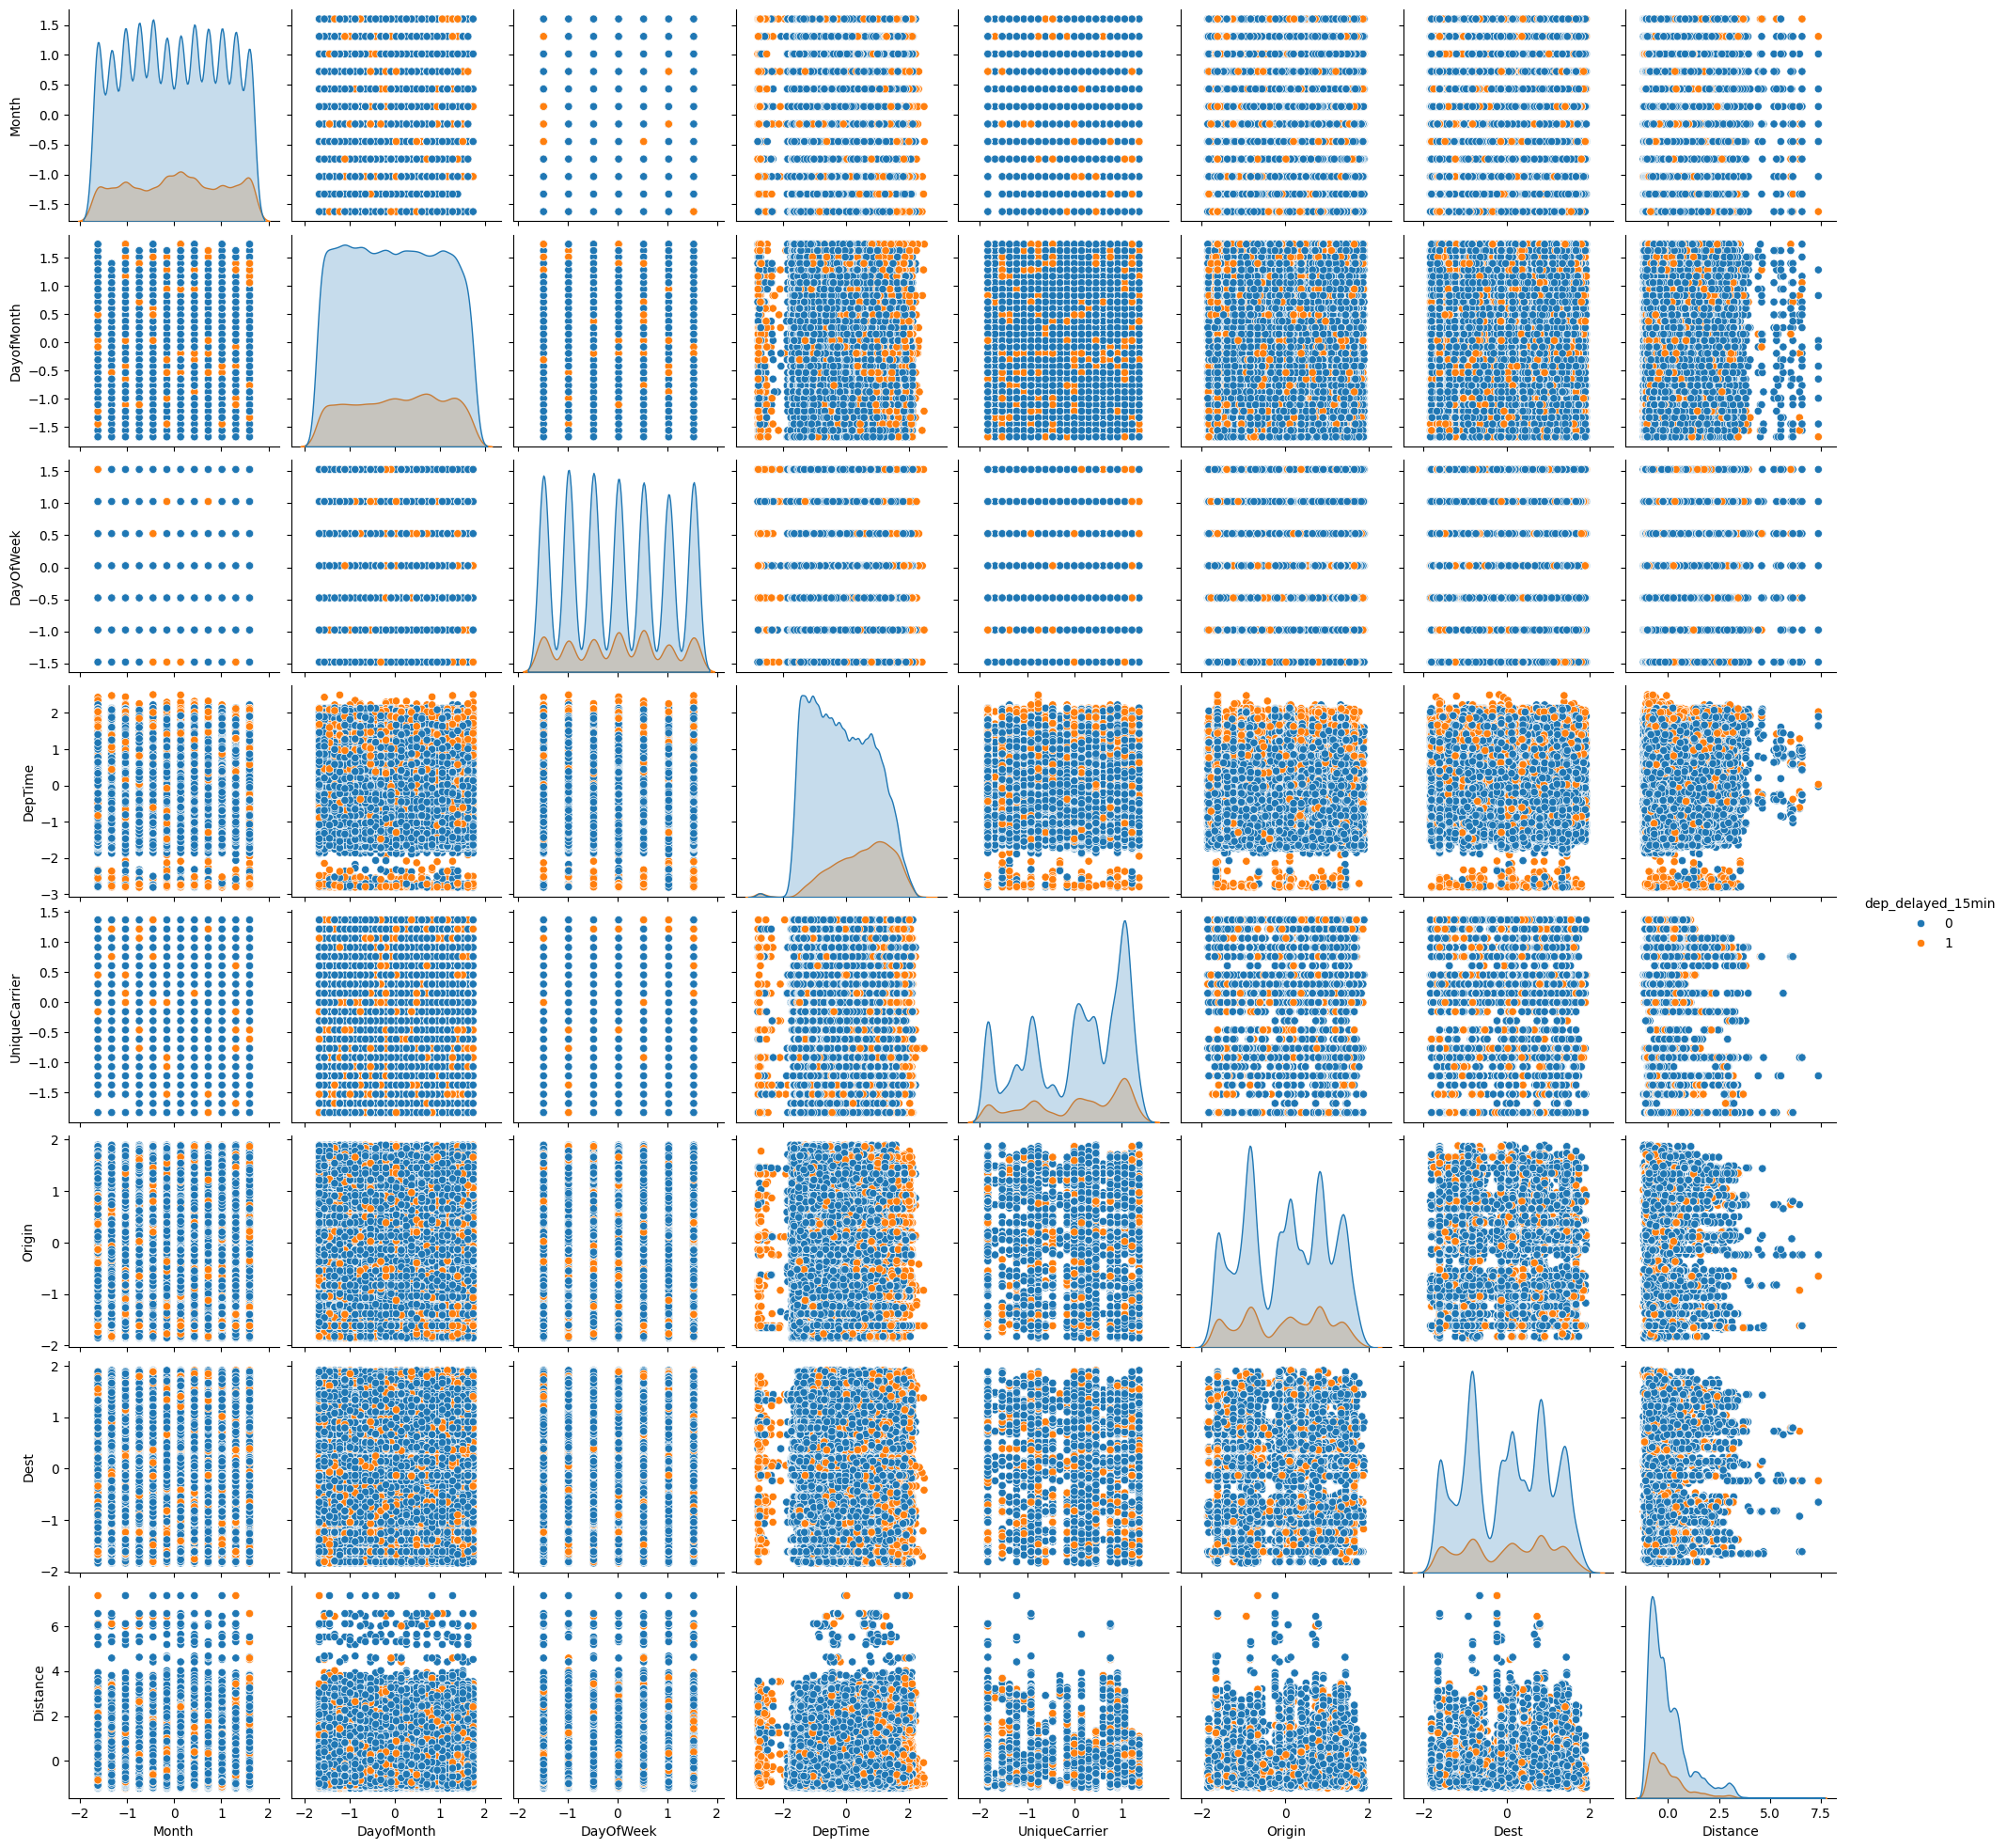

In [6]:
sns.pairplot(data_set, hue='dep_delayed_15min')
plt.show()

By having a quick look on the pairplot of the dataset, we can see that DepTime feature is a nice feature for predicting. Other than that, some combinations of the features might also work for predictions. We will try using all features and then only the DepTime feature and compare the results.

# Training Models

Before training, we need to separate the labels from features and also split the data to train and test sets. Selecting 80/20 ratio for splitting.

In [7]:
y = data_set['dep_delayed_15min']
x = data_set.drop('dep_delayed_15min', axis=1)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=SPLIT_TEST_SIZE, random_state=SPLIT_RANDOM_STATE, shuffle=True)

Import necessary libraries:

In [8]:
from lib.dt import fit_decision_tree
from lib.rf import fit_random_forest
from lib.svm import fit_svm
from lib.dnn import fit_basic_dnn, fit_embedded_dnn

2024-08-11 13:53:36.493178: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-11 13:53:36.505215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 13:53:36.521612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 13:53:36.524232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-11 13:53:36.531686: I tensorflow/core/platform/cpu_feature_guar

## Decision Tree Classifiers

In [9]:
dt_list = []
for i in range(1, 9):
    depth = i*8
    print("\nDecision Tree with max depth: ", depth)
    dt = fit_decision_tree(x_train, y_train, depth)
    dt_list.append([dt, depth])


Decision Tree with max depth:  8

Decision Tree with max depth:  16

Decision Tree with max depth:  24

Decision Tree with max depth:  32

Decision Tree with max depth:  40

Decision Tree with max depth:  48

Decision Tree with max depth:  56

Decision Tree with max depth:  64


## Random Forest Classifiers

In [10]:
rf_list = []
for i in range(1, x_train.shape[1]-2):
    max_features = i
    print("\nRandom Forest with max features: ", max_features)
    rf = fit_random_forest(x_train, y_train, max_features)
    rf_list.append([rf, max_features])


Random Forest with max features:  1

Random Forest with max features:  2

Random Forest with max features:  3

Random Forest with max features:  4

Random Forest with max features:  5


## SVM

In [11]:
svm = fit_svm(x_train, y_train)

## DNN

In [12]:
dnn = fit_basic_dnn(x_train, y_train, num_epochs=50, batch_size=32)

Epoch 1/50


I0000 00:00:1723374178.644308   94416 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723374178.671846   94416 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723374178.673703   94416 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723374178.676762   94416 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

 159/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 959us/step - accuracy: 0.5749 - loss: 0.7781

I0000 00:00:1723374183.369567   95014 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 924us/step - accuracy: 0.7486 - loss: 0.5615
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 909us/step - accuracy: 0.8077 - loss: 0.4675
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 907us/step - accuracy: 0.8069 - loss: 0.4644
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 887us/step - accuracy: 0.8071 - loss: 0.4623
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 860us/step - accuracy: 0.8087 - loss: 0.4601
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 966us/step - accuracy: 0.8077 - loss: 0.4615
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 886us/step - accuracy: 0.8092 - loss: 0.4558
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 934us/step - accuracy: 0.8092 - loss: 0.4568
Epoch 9/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 843us/step - accuracy: 0.8103 - loss: 0.4538
Epoch 10/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 955us/step - accuracy: 0.8072 - loss: 0.4586
Epoch 11/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 966us/step - accuracy: 0.8097 - loss: 0.4534
Epoch 12/50
2500/25

## Embedded DNN

In [13]:
embedded_dnn = fit_embedded_dnn(x_train, y_train, num_epochs=50, batch_size=32)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8039 - loss: 0.5022
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8086 - loss: 0.4670
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8077 - loss: 0.4640
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8100 - loss: 0.4590
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8113 - loss: 0.4552
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8117 - loss: 0.4541
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8086 - loss: 0.4561
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8081 - loss: 0.4561
Epoch 9/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8070 - loss: 0.4583
Epoch 10/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8098 - loss: 0.4536
Epoch 11/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8105 - loss: 0.4498
Epoch 12/50
2500/2500 ━━━━━━━━

## Random Forest with less Features

In [14]:
importances = rf_list[3][0].feature_importances_
indices = np.argsort(importances)[::-1]
top_features = x_train.columns[indices][:3]
modified_random_forest = fit_random_forest(x_train[top_features], y_train, max_features)

# Metrics

Import necessary libraries:

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [16]:
def get_auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

## Decision Tree Classifiers

### Test Set Metrics

In [17]:
for tuple in dt_list:
    dt = tuple[0]
    max_depth = tuple[1]

    print("\nDecision Tree with max depth: ", max_depth)
    y_pred = dt.predict(x_test)
    print(classification_report(y_test, y_pred))
    print("AUC Score: ", get_auc_score(y_test, y_pred))


Decision Tree with max depth:  8
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     16211
           1       0.54      0.07      0.13      3789

    accuracy                           0.81     20000
   macro avg       0.68      0.53      0.51     20000
weighted avg       0.77      0.81      0.75     20000

AUC Score:  0.5299339768755202

Decision Tree with max depth:  16
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     16211
           1       0.36      0.21      0.27      3789

    accuracy                           0.78     20000
   macro avg       0.60      0.56      0.57     20000
weighted avg       0.74      0.78      0.76     20000

AUC Score:  0.5633240181657571

Decision Tree with max depth:  24
              precision    recall  f1-score   support

           0       0.84      0.83      0.84     16211
           1       0.31      0.32      0.31      3789

    accuracy    

### Train Set Metrics

In [18]:
for tuple in dt_list:
    dt = tuple[0]
    max_depth = tuple[1]

    print("\nDecision Tree with max depth: ", max_depth)
    y_pred = dt.predict(x_train)
    print(classification_report(y_train, y_pred))
    print("AUC Score: ", get_auc_score(y_train, y_pred))


Decision Tree with max depth:  8
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     64745
           1       0.67      0.09      0.16     15255

    accuracy                           0.82     80000
   macro avg       0.75      0.54      0.53     80000
weighted avg       0.79      0.82      0.76     80000

AUC Score:  0.5408801019778599

Decision Tree with max depth:  16
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     64745
           1       0.90      0.50      0.64     15255

    accuracy                           0.89     80000
   macro avg       0.89      0.74      0.79     80000
weighted avg       0.89      0.89      0.88     80000

AUC Score:  0.7415393050805495

Decision Tree with max depth:  24
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     64745
           1       0.99      0.93      0.96     15255

    accuracy    

## Random Forest Classifiers

### Test Set Metrics

In [19]:
for tuple in rf_list:
    rf = tuple[0]
    max_features = tuple[1]

    print("\Random Forest with max features: ", max_features)
    y_pred = rf.predict(x_test)
    print(classification_report(y_test, y_pred))
    print("AUC Score: ", get_auc_score(y_test, y_pred))

\Random Forest with max features:  1


<>:5: SyntaxWarning: invalid escape sequence '\R'
<>:5: SyntaxWarning: invalid escape sequence '\R'
/tmp/ipykernel_94416/2886953250.py:5: SyntaxWarning: invalid escape sequence '\R'
  print("\Random Forest with max features: ", max_features)


              precision    recall  f1-score   support

           0       0.82      0.99      0.90     16211
           1       0.64      0.08      0.14      3789

    accuracy                           0.82     20000
   macro avg       0.73      0.53      0.52     20000
weighted avg       0.79      0.82      0.75     20000

AUC Score:  0.5344066150990894
\Random Forest with max features:  2
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     16211
           1       0.63      0.12      0.20      3789

    accuracy                           0.82     20000
   macro avg       0.73      0.55      0.55     20000
weighted avg       0.79      0.82      0.77     20000

AUC Score:  0.5502063714105154
\Random Forest with max features:  3
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     16211
           1       0.65      0.13      0.22      3789

    accuracy                           0.82   

### Train Set Metrics

In [20]:
for tuple in rf_list:
    rf = tuple[0]
    max_features = tuple[1]

    print("\Random Forest with with max features: ", max_features)
    y_pred = rf.predict(x_train)
    print(classification_report(y_train, y_pred))
    print("AUC Score: ", get_auc_score(y_train, y_pred))

\Random Forest with with max features:  1


<>:5: SyntaxWarning: invalid escape sequence '\R'
<>:5: SyntaxWarning: invalid escape sequence '\R'
/tmp/ipykernel_94416/3516131455.py:5: SyntaxWarning: invalid escape sequence '\R'
  print("\Random Forest with with max features: ", max_features)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64745
           1       1.00      1.00      1.00     15255

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000

AUC Score:  1.0
\Random Forest with with max features:  2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64745
           1       1.00      1.00      1.00     15255

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000

AUC Score:  0.9998688954441166
\Random Forest with with max features:  3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64745
           1       1.00      1.00      1.00     15255

    accuracy                           1.00     800

## SVM

### Test Set Metrics

In [21]:
y_pred = svm.predict(x_test)
print(classification_report(y_test, y_pred, zero_division=1))
print("AUC Score: ", get_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     16211
           1       1.00      0.00      0.00      3789

    accuracy                           0.81     20000
   macro avg       0.91      0.50      0.45     20000
weighted avg       0.85      0.81      0.73     20000

AUC Score:  0.5


### Train Set Metrics

In [22]:
y_pred = svm.predict(x_test)
print(classification_report(y_test, y_pred, zero_division=1))
print("AUC Score: ", get_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     16211
           1       1.00      0.00      0.00      3789

    accuracy                           0.81     20000
   macro avg       0.91      0.50      0.45     20000
weighted avg       0.85      0.81      0.73     20000

AUC Score:  0.5


## DNN

### Test Set Metrics

In [23]:
y_pred = dnn.predict(x_test)
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_test, y_pred, zero_division=1))
print("AUC Score: ", get_auc_score(y_test, y_pred))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step
              precision    recall  f1-score   support

           0       0.81      0.99      0.90     16211
           1       0.56      0.03      0.06      3789

    accuracy                           0.81     20000
   macro avg       0.69      0.51      0.48     20000
weighted avg       0.77      0.81      0.74     20000

AUC Score:  0.5133096743022322


### Train Set Metrics

In [24]:
y_pred = dnn.predict(x_train)
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_train, y_pred, zero_division=1))
print("AUC Score: ", get_auc_score(y_train, y_pred))

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step
              precision    recall  f1-score   support

           0       0.81      0.99      0.90     64745
           1       0.62      0.04      0.07     15255

    accuracy                           0.81     80000
   macro avg       0.71      0.52      0.48     80000
weighted avg       0.78      0.81      0.74     80000

AUC Score:  0.5152373103579914


## Embedded DNN

### Test Set Metrics

In [25]:
y_pred = embedded_dnn.predict([x_test['UniqueCarrier'], x_test['Origin'], x_test['Dest'], x_test['Month'], x_test['DayofMonth'], x_test['DayOfWeek'], x_test['DepTime'], x_test['Distance']])
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_test, y_pred, zero_division=1))
print("AUC Score: ", get_auc_score(y_test, y_pred))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     16211
           1       0.52      0.02      0.04      3789

    accuracy                           0.81     20000
   macro avg       0.66      0.51      0.47     20000
weighted avg       0.76      0.81      0.73     20000

AUC Score:  0.5087492194963428


### Train Set Metrics

In [26]:
y_pred = embedded_dnn.predict([x_train['UniqueCarrier'], x_train['Origin'], x_train['Dest'], x_train['Month'], x_train['DayofMonth'], x_train['DayOfWeek'], x_train['DepTime'], x_train['Distance']])
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_train, y_pred, zero_division=1))
print("AUC Score: ", get_auc_score(y_train, y_pred))

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 837us/step
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     64745
           1       0.66      0.03      0.05     15255

    accuracy                           0.81     80000
   macro avg       0.74      0.51      0.47     80000
weighted avg       0.78      0.81      0.73     80000

AUC Score:  0.5120901732862748


## Random Forest with Less Features

### Test Set Metrics

In [27]:
y_pred = modified_random_forest.predict(x_test[top_features])
print(classification_report(y_test, y_pred, zero_division=1))
print("AUC Score: ", get_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     16211
           1       0.49      0.25      0.33      3789

    accuracy                           0.81     20000
   macro avg       0.67      0.59      0.61     20000
weighted avg       0.78      0.81      0.78     20000

AUC Score:  0.5945297969852863


### Train Set Metrics

In [28]:
y_pred = modified_random_forest.predict(x_train[top_features])
print(classification_report(y_train, y_pred, zero_division=1))
print("AUC Score: ", get_auc_score(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     64745
           1       0.99      0.98      0.99     15255

    accuracy                           0.99     80000
   macro avg       0.99      0.99      0.99     80000
weighted avg       0.99      0.99      0.99     80000

AUC Score:  0.9878815383417167


# (For Kaggle) Test Set Prediction

In [29]:
# Read the test data
test_data = pd.read_csv('data/flight_delays_test.csv')
test_data = preprocess_data(test_data)

print(test_data.head())

# Make predictions using the random forest model
predictions = embedded_dnn.predict([test_data['UniqueCarrier'], test_data['Origin'], test_data['Dest'], test_data['Month'], test_data['DayofMonth'], test_data['DayOfWeek'], test_data['DepTime'], test_data['Distance']])
predictions = predictions.flatten()
print(predictions)

# Create a DataFrame with the Id and pred columns
results = pd.DataFrame({'id': test_data.index, 'dep_delayed_15min': predictions})

# Save the results to a CSV file
results.to_csv('predictions.csv', index=False)

      Month  DayofMonth  DayOfWeek   DepTime  UniqueCarrier    Origin  \
0  0.139373    1.057834  -0.468288 -1.506470       1.340647  0.589746   
1 -0.738624    0.147740  -0.970485 -1.248433       1.000992  0.095055   
2  1.602703   -1.558686   1.540499 -1.431556      -0.017973 -0.336213   
3 -1.031290    1.057834   1.540499  0.572391       1.000992 -1.249488   
4 -0.153293   -1.103639  -0.468288  0.345568       0.661337  0.780011   

       Dest  Distance  
0  0.890651 -0.222169  
1 -0.232845  0.908827  
2  0.775748 -0.259455  
3  0.456573 -0.614555  
4  1.567301 -0.825840  
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 807us/step
[0.04616267 0.07288844 0.05915852 ... 0.20144245 0.13336557 0.143063  ]
